In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1260
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
ERROR: LoadError: ArgumentError: Package Flux does not have CuArrays in its dependencies:
- If you have Flux checked out for development and have
  added CuArrays as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with Flux
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:905
 [2] include(::Module, ::String) at ./Base.jl:377
 [3] top-level scope at none:2
 [4] eval at ./boot.jl:331 [inlined]
 [5] eval(::Expr) at ./client.jl:449
 [6] top-level scope at ./none:3
in expression starting at /home/vavrines/.julia/packages/Flux/Fj3bt/src/Flux.jl:26


ErrorException: Failed to precompile Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] to /home/vavrines/.julia/compiled/v1.4/Flux/QdkVy_6HVpI.ji.

In [2]:
config = "config.txt"
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d2f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.7
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 80
pMeshType = uniform
nxg = 1
umin = -10.0
umax = 10.0
nu = 64
nug = 0
vmin = -10.0
vmax = 10.0
nv = 28
nvg = 0
wmin = -10.0
wmax = 10.0
nw = 28
nwg = 0
vMeshType = rectangle
knudsen = 1.0
mach = 3.0
prandtl = 0.6666667
inK = 2
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
nm = 5
tLen = 3
nh = 12



In [3]:
γ = heat_capacity_ratio(inK, 1)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)
wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR = ib_rh(mach, γ, vSpace.u, inK)
ib = IB2F(wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR)
ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd())

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.018620167f0:0.037240334f0

In [4]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [5]:
sumRes = zeros(3)
@showprogress for iter = 1:2000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, sumRes)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [6]:
function shakhov!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

function generate_data(ks, ctr)
    nx = ks.pSpace.nx
    nu = ks.vSpace.nu
    
    X = Array{Float32}(undef, nu * 2, nx)
    for i = 1:nx
        X[1:nu, i] .= ctr[i].h
        X[nu+1:end, i] .= ctr[i].b
    end
    
    H = Array{Float32}(undef, nu, size(X, 2))
    B = Array{Float32}(undef, nu, size(X, 2))
    SH = Array{Float32}(undef, nu, size(X, 2))
    SB = Array{Float32}(undef, nu, size(X, 2))
    τ = Array{Float32}(undef, 1, size(X, 2))
    for i in axes(X, 2)
        H[:, i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
        B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* ctr[i].prim[end])

        q = heat_flux(ctr[i].h, ctr[i].b, ctr[i].prim, ks.vSpace.u, ks.vSpace.weights)
        H1, B1 = shakhov(ks.vSpace.u, H[:,i], B[:,i], q, ctr[i].prim, ks.gas.Pr, ks.gas.K)
        SH[:,i] .= H[:,i] .+ H1
        SB[:,i] .= B[:,i] .+ B1

        τ[1, i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
    end
    P = [SH, SB, τ]
    M = vcat(H, B)

    prob = ODEProblem(shakhov!, X, tspan, P)
    Y = solve(prob, Euler(), dt=dt) |> Array;
    
    return X, Y, H, B, M, τ
end

generate_data (generic function with 1 method)

In [7]:
X, Y, H, B, M, τ = generate_data(ks, ctr);

In [41]:
ann = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(nu * 2, nu * 2 * nh, tanh),
    FastDense(nu * 2 * nh, nu * 2 * nh, tanh),
    FastDense(nu * 2 * nh, nu * 2),
)

p_model = initial_params(ann)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ ann(f .- M, p)[1:nu, :]
    db = (B .- b) ./ τ .+ ann(f .- M, p)[nu+1:end, :]

    df = vcat(dh, db)
end

ode_prob = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    #sol = solve(ode_prob, Midpoint(), u0=X, p=p, saveat=tran)
    sol = solve(ode_prob, Euler(), u0=X, p=p, dt=dt)
    loss = sum(abs2, Array(sol) .- Y)
    return loss
end

cb = function (p, l)
    #display(l)
    return false
end

res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

loss: 7.29e-07: 100%|█████████████████████████████████████████| Time: 0:01:35


 * Status: success

 * Candidate solution
    Final objective value:     7.292677e-07

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   99  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [49]:
function ube_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ ann(f .- [H; B], p_nn)[1:nu]
    db = (B .- b) ./ τ .+ ann(f .- [H; B], p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    ube_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
);

In [50]:
function step_ube!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR;
    p,
    mode = :shakhov,
)
    
    # extract parameters
    K, γ, μ, ω, u, weights, p_nn, dx, tran, RES, AVG = p
    
    # record W^{n}
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)

    # update f^{n+1}
    if mode == :shakhov
        qf = heat_flux(h, b, prim, u, weights)
        H1, B1 = shakhov(u, H, B, qf, prim, ks.gas.Pr, K)
        SH = H .+ H1
        SB = B .+ B1
        
        hstar = @. h + (SH - h) / τ * dt
        bstar = @. b + (SB - b) / τ * dt
    elseif mode == :nn
        sol = solve(ube, Euler(), u0=[h; b], p=[H; B; τ; res.minimizer], dt=dt)
        #sol = solve(ube, Midpoint(), u0=[h; b], p=[H; B; τ; p_nn], saveat=tran)
        #sol = solve(ube, Midpoint(), u0=[h; b], p=[SH; SB; τ; p_nn], saveat=tran)
        hstar = sol.u[end][1:length(h)]
        bstar = sol.u[end][length(h)+1:end]
    end
    
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end
        
    # update W^{n+1}
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    # record residuals
    @. RES += (w - w_old)^2
    @. AVG += abs(w)
        
end

step_ube! (generic function with 1 method)

In [44]:
sumRes = zeros(Float32, axes(ks.ib.wL));
sumAvg = zeros(Float32, axes(ks.ib.wL));

@showprogress for iter = 1:200
    Kinetic.evolve!(ks, ctr, face, dt)
    
    for i = 2:49
        p = (ks.gas.K, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, ks.vSpace.u, ks.vSpace.weights, res.minimizer, ctr[i].dx, tran, sumRes, sumAvg)
        step_ube!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            p=p,
            mode=:shakhov,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [45]:
X, Y, H, B, M, τ = generate_data(ks, ctr)
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200, save_best=true)

In [51]:
@showprogress for iter = 1:20
    Kinetic.evolve!(ks, ctr, face, dt)
    
    for i = 2:49
        p = (ks.gas.K, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, ks.vSpace.u, ks.vSpace.weights, res.minimizer, ctr[i].dx, tran, sumRes, sumAvg)
        step_ube!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            p=p,
            mode=:nn,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


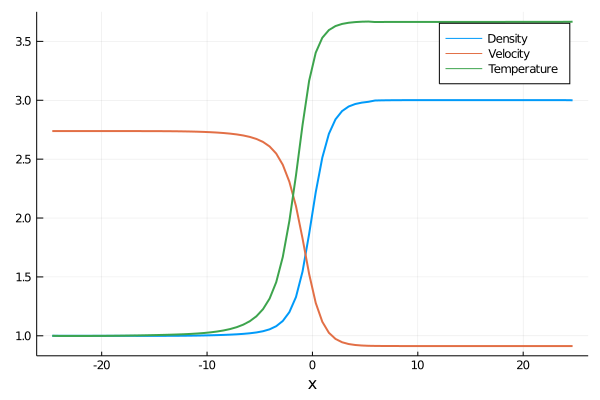

In [52]:
plot_line(ks, ctr)

In [ ]:
@save "sol_shakhov.jld2" ks ctr ann res